# 1  ||  Classification on MNIST

In [1]:
# Importing Libraries
import matplotlib.pyplot as plt
import tensorflow as tf
import cvxpy as cp
import numpy as np
from cvxpy import *
import numpy, cvxopt, cvxopt.solvers, scipy, scipy.spatial, random, time
from numpy import linalg

2022-03-15 17:10:29.439834: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-15 17:10:29.439863: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Data

In [2]:
# Load data and Preprocess
mnist = tf.keras.datasets.mnist

# Includes all numbers from 0 to 9
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Retain only 2s and 6s: Index of Numbers 2 and 6 in training and testing data
index_train = np.where((train_labels == 2) | (train_labels == 6))
index_test = np.where((test_labels == 2) | (test_labels == 6))

# train images + labesl: 2s&6s only
train_images_26 = train_images[index_train]
train_images_26 = train_images_26.reshape((len(train_images_26), train_images_26[1].size))

train_labels_26 = train_labels[index_train].astype('int')

# test images + labesl: 2s&6s only
test_images_26 = test_images[index_test]
test_images_26 = test_images_26.reshape((len(test_images_26), test_images_26[1].size))

test_labels_26 = test_labels[index_test].astype('int')


# Change labels from '2' and '6' to '-1' and '+1'
train_labels_26[np.where(train_labels_26 == 2)] = -1
train_labels_26[np.where(train_labels_26 == 6)] = 1

test_labels_26[np.where(test_labels_26 == 2)] = -1
test_labels_26[np.where(test_labels_26 == 6)] = 1

**Normalizing and Subsetting Training Dataset**

In [3]:
# Normalize the Train & test
x_train = train_images_26.astype('float32')
x_test = test_images_26.astype('float32')

y_train = train_labels_26.astype('float32')
y_test = test_labels_26.astype('float32')

x_train /= 255
y_train /= 255

# Choose a subset of the entire training dataset
x_train = x_train[range(10000)]
y_train = train_labels_26[range(10000)]

# Check the dimension, the feature vector of each sample shall be 785
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(10000, 784) (1990, 784)
(10000,) (1990,)


In [4]:
# define X and y for xtrain, save shapes as variables
X,y  = x_train, y_train
y_org = y
print(X.shape, y.shape)

m,n = np.shape(X)
print(m, n)

(10000, 784) (10000,)
10000 784


## Problem 1

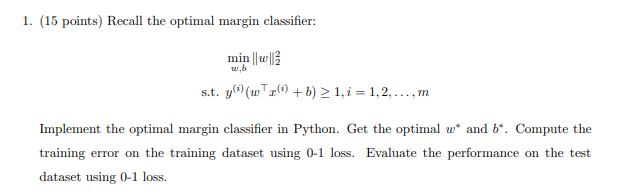

### Implement the optimal margin classifier

In [5]:
W = cp.Variable(n)
slack = cp.Variable(m) # for soft svm (not needed for hard SVM)
b = cp.Variable() #gamma

# objective function: hard SVM
obj = cp.Minimize(0.5 * cp.square(cp.norm(W)))

# constraints
constr = [cp.matmul(y, X @ W + b) >= 1]
# problem
prob = cp.Problem(obj, constr)
# solve
result = prob.solve()

print("Optimisation status:", prob.status, "\n")
print("Optimal value of w", W.value, "\n")
print("Optimal value of b", b.value, "\n")

Optimisation status: optimal 

Optimal value of w [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.09042912e-09  3.90908528e-10 -2.22200653e-09 -9.25836086e-11
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.64593084e-10  5.65788708e-10  5.72989662e-09  1.41755788e-08
  1.74571533e-08  2.44420725e-08  4.29073603e-08  6.39341312e-08
  7.56305315e-08  7.91898584e-08  7.36657007e-08  6.14960951e-08
  5.13633314e-08  5.74429897e-08  4.32365466e-08  3.27437364e-08
  2.81248428e-08  1.04516605e-08  5.02008896e-09  2.18085827e-09
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  6.5837

### Evaluate the performance on the train set (0-1 loss)

In [6]:
train_preds = []

for i in range(X.shape[0]):
    train_preds.append(np.sign(np.dot(np.array(X[i]), W.value) + b.value))
    
y_train.shape, len(train_preds)

((10000,), 10000)

In [7]:
import math

In [8]:
def hinge_fun(actual, predicted):
    # replacing 0 = -1
    new_predicted = np.array([-1 if i==0 else i for i in predicted])
    
    # calculating hinge loss
    hinge_loss = np.mean([np.maximum(0, 1-x*y) for x, y in zip(actual, new_predicted)])
    return hinge_loss

hinge_fun(y_train, np.array(train_preds, dtype="int32"))

0.1142

### Evaluate Performance on test set

In [9]:
test_preds = []

for i in range(x_test.shape[0]):
    test_preds.append(np.sign(np.dot(np.array(x_test[i]), W.value) + b.value))
    
print(len(test_preds))

1990


In [10]:
hinge_fun(y_test, np.array(test_preds, dtype="int32"))

0.09246231155778895

## Problem 2

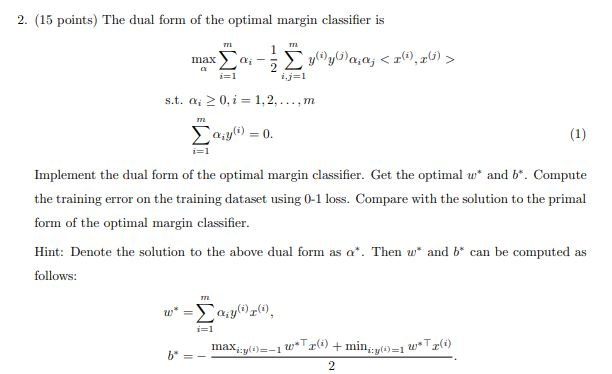

### Implement the dual form of the classifier

In [12]:
def svm_dual(X, y, slack):
    # attributes + n of them
    m,n = X.shape
    # make y a float
    y = y.reshape(-1, 1) * 1
    # matrices
    H = np.dot(y * X, (y * X).T) * 1
    P = cvxopt.matrix(H)
    q = cvxopt.matrix(-np.ones((m,1)))
    G = cvxopt.matrix(np.vstack((np.eye(m)*-1, np.eye(m))))
    h = cvxopt.matrix(np.hstack((np.zeros(m), np.ones(m) * slack)))
    A = cvxopt.matrix(y.reshape(1, -1))
    b = cvxopt.matrix(np.zeros(1))
    
    # change a and p typecodes
    P = cvxopt.base.matrix(P, (10000, 10000), 'd')
    A = cvxopt.base.matrix(A, (1, 10000), 'd')

    # solver
    sol = cvxopt.solvers.qp(P, q, G, h, A, b)
    
    # alphas
    alphas = np.array(sol['x'])
    threshold = 0.0001
    
    # w and b
    w = ((y * alphas).T @ X).reshape(-1,1)
    S = (alphas > threshold).flatten()
    b = y[S] - np.dot(X[S], w)
    
    return w, b

In [13]:
w_dual, b_dual = svm_dual(X, y, 1)
w_dual, b_dual

     pcost       dcost       gap    pres   dres
 0: -1.2818e+03 -2.3985e+04  1e+05  3e+00  2e-12
 1: -7.9395e+02 -1.4864e+04  3e+04  5e-01  2e-12
 2: -4.7584e+02 -5.3752e+03  9e+03  1e-01  1e-12
 3: -3.4255e+02 -3.1457e+03  5e+03  7e-02  9e-13
 4: -2.4184e+02 -1.6651e+03  2e+03  3e-02  8e-13
 5: -1.9657e+02 -1.0463e+03  1e+03  2e-02  7e-13
 6: -1.6390e+02 -7.5834e+02  9e+02  9e-03  7e-13
 7: -1.4540e+02 -5.7878e+02  6e+02  5e-03  7e-13
 8: -1.4137e+02 -3.0518e+02  2e+02  1e-03  7e-13
 9: -1.4611e+02 -2.4854e+02  1e+02  4e-04  7e-13
10: -1.5771e+02 -2.1198e+02  6e+01  1e-04  7e-13
11: -1.6238e+02 -1.9454e+02  3e+01  4e-05  8e-13
12: -1.7014e+02 -1.7976e+02  1e+01  6e-07  9e-13
13: -1.7265e+02 -1.7632e+02  4e+00  1e-07  8e-13
14: -1.7395e+02 -1.7472e+02  8e-01  4e-09  9e-13
15: -1.7430e+02 -1.7434e+02  4e-02  6e-12  9e-13
16: -1.7432e+02 -1.7432e+02  5e-04  9e-14  9e-13
17: -1.7432e+02 -1.7432e+02  6e-06  2e-15  9e-13
Optimal solution found.


(array([[ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 1.16420155e-10],
        [ 2.17438709e-10],
        [-4.17094988e-11],
        [-1.73789584e-12],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 6.45978226e-12],
        [ 2.14050484e-11],
        [ 1.72189891e-10],
        [ 4.76314306e-10],
        [ 1.69408272e-09],
 

### Evaluate the performance on the training set

In [68]:
train_preds_dual = []

flattened_w = [item for sublist in w_dual for item in sublist]
flattened_b = [item for sublist in b_dual for item in sublist]

for i in range(X.shape[0]):
    train_preds_dual.append(np.sign(np.dot(np.array(X[i]), np.array(flattened_w)) + np.mean(flattened_b)))
    
print(y_train.shape, len(train_preds_dual))

(10000,) 10000


In [69]:
hinge_fun(y_train, np.array(train_preds_dual, dtype="int32"))

0.008

### Evaluate the performance on the training set

In [70]:
test_preds_dual = []

for i in range(x_test.shape[0]):
    test_preds_dual.append(np.sign(np.dot(np.array(x_test[i]), np.array(flattened_w)) + np.mean(flattened_b)))
    
print(y_test.shape, len(test_preds_dual))

(1990,) 1990


In [71]:
hinge_fun(y_test, np.array(test_preds_dual, dtype="int32"))

0.04020100502512563

## Problem 3

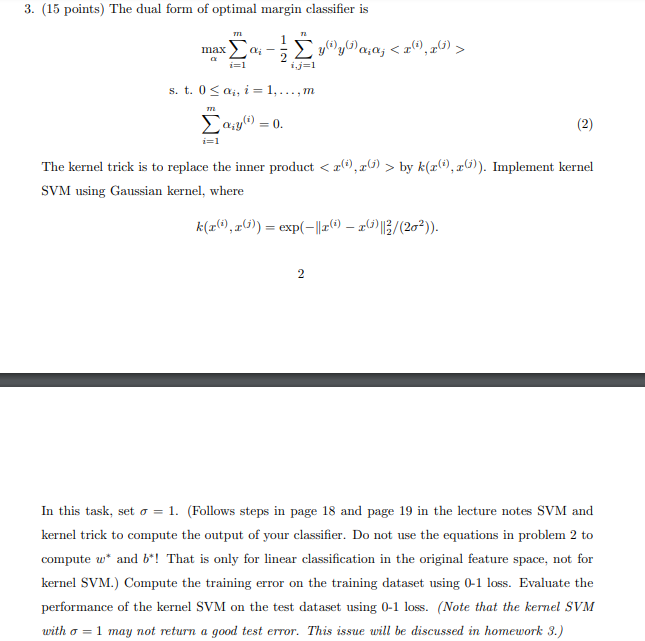

### Implementation

- The kernel provided is a gaussian kernel

In [134]:
class SVM():
    
    def __init__(self, max_iter=10000, kernel_type='gaussian', C=1.0, epsilon=0.001):
        self.kernels = {
            'gaussian' : self.kernel_gaussian,
        }
        self.max_iter = max_iter
        self.kernel_type = kernel_type
        self.C = C
        self.epsilon = epsilon
        
    def kernel_gaussian(self, x1, x2, sigma=1):
        return np.exp(-linalg.norm(x1-x2)**2 / (2 * (sigma ** 2)))
    
    def fit(self, X, y):
        # n : number of samples (100)
        n = X.shape[0]
        
        #we have alpha per sample of training set. Initially set to zeros
        alpha = np.zeros((n))
        
        #pick the kernel user selected
        kernel = self.kernels[self.kernel_type]
        
        
        iteration = 0
        while True:
            iteration += 1
            
            #saving the copy of alpha from previous iteration
            alpha_prev = np.copy(alpha)
            
            #going through all the samples in one iteration
            for j in range(0, n):
                
                #selcting random sample index where i is not equal to j
                i = self.get_rnd_int(0, n-1, j) # Get random int i~=j
                
                x_i = X[i,:]
                x_j = X[j,:]
                y_i = y[i]
                y_j = y[j]
                
                k_ij = kernel(x_i, x_i) + kernel(x_j, x_j) - 2 * kernel(x_i, x_j)
                
                if k_ij == 0:
                    continue
                
                #select alpha of i and j from the alpha array to calculate L and H
                alpha_prime_j, alpha_prime_i = alpha[j], alpha[i]
                (L, H) = self.compute_L_H(self.C, alpha_prime_j, alpha_prime_i, y_j, y_i)

                # Compute model parameters
                self.w = self.calc_w(alpha, y, X)
                self.b = self.calc_b(X, y, self.w)

                # Compute E_i, E_j
                E_i = self.E(x_i, y_i, self.w, self.b)
                E_j = self.E(x_j, y_j, self.w, self.b)

                # Set new alpha values
                j = int(j)
                alpha[j] = alpha_prime_j + float(y_j * (E_i - E_j))/k_ij
                alpha[j] = np.maximum(alpha[j], L)
                alpha[j] = np.minimum(alpha[j], H)

                alpha[i] = alpha_prime_i + y_i*y_j * (alpha_prime_j - alpha[j])

            # Terminating condition: reacing convergence
            diff = np.linalg.norm(alpha - alpha_prev)
            if diff < self.epsilon:
                break

            #Terminating condition: Reaching max iterations
            if iteration >= self.max_iter:
                print("Iteration number exceeded the max of %d iterations" % (self.max_iter))
                return
            
        # Compute final model parameters
        self.b = self.calc_b(X, y, self.w)
        if self.kernel_type == 'linear':
            self.w = self.calc_w(alpha, y, X)
            
            
    def predict(self, X):
        return self.h(X, self.w, self.b)
    
    def calc_b(self, X, y, w):
        b_tmp = y - np.dot(w.T, X.T)
        return np.mean(b_tmp)
    
    def calc_w(self, alpha, y, X):
        return np.dot(alpha * y, X)
    
    # Prediction
    def h(self, X, w, b):
        return np.sign(np.dot(w.T, X.T) + b).astype(int)
    
    # Prediction error
    def E(self, x_k, y_k, w, b):
        return self.h(x_k, w, b) - y_k
    
    def compute_L_H(self, C, alpha_prime_j, alpha_prime_i, y_j, y_i):
        if(y_i != y_j):
            return (np.maximum(0, alpha_prime_j - alpha_prime_i), np.minimum(C, C - alpha_prime_i + alpha_prime_j))
        else:
            return (np.maximum(0, alpha_prime_i + alpha_prime_j - C), np.minimum(C, alpha_prime_i + alpha_prime_j))
        
    def get_rnd_int(self, a,b,z):
        i = z
        cnt=0
        while i == z and cnt<1000:
            i = rnd.randint(a,b)
            cnt=cnt+1
        return i


In [135]:
svm = SVM(max_iter=10000, kernel_type='gaussian', C=1.0, epsilon=0.001)

In [137]:
import random as rnd

w_kernel, b_kernel = svm.fit(x_train, y_org)
w_kernel, b_kernel

### Evaluation on Train set

In [ ]:
train_preds_kernel = []

for i in range(X.shape[0]):
    train_preds_kernel.append(np.sign(np.dot(np.array(X[i]), w_dual.value) + b_dual.value))
    
print(y_train.shape, len(train_preds_kernel))

hinge_fun(y_train, np.array(train_preds_kernel, dtype="int32"))

### Evaluation on Test set

In [144]:
test_preds_kernel = []

for i in range(x_test.shape[0]):
    test_preds_kernel.append(np.sign(np.dot(np.array(x_test[i]), w_dual.value) + b_dual.value))
    
print(y_test.shape, len(test_preds_kernel))

hinge_fun(y_test, np.array(test_preds_kernel, dtype="int32"))

## Problem 4

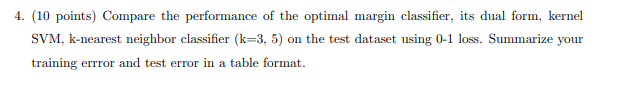

### KNN

In [138]:
def euc_dis(data, xtrain):
    diff = np.tile(data, [len(xtrain), 1])
    dis = (diff - xtrain) ** 2
    dis = dis.sum(axis=1) # Sum each line
    dis = dis**0.5
    return dis

def classify(data, xtrain, labels, diff_func, k):
    r = np.zeros(len(data), dtype=np.int)
    for i, d in enumerate(data):
        diff = diff_func(d, xtrain)
        diff_sort_arg = diff.argsort() #Sort get index
        label_count = {}
        # Calculate the most categories of k data
        for l in labels[diff_sort_arg[:k]]:
            label_count[l] = label_count.get(l, 0) + 1
        r[i] = sorted(label_count.items(), key=lambda a: a[1], reverse=True)[0][0]
        
    return r

In [139]:
train_knn_3_pred = classify(x_train, x_train, y_train, euc_dis, k=3)
y_train.shape, train_knn_3_pred.shape

/tmp/ipykernel_6618/4016568851.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  r = np.zeros(len(data), dtype=np.int)


((10000,), (10000,))

In [140]:
test_knn_3_pred = classify(x_test, x_test, y_test, euc_dis, k=3)
y_test.shape, test_knn_3_pred.shape

/tmp/ipykernel_6618/4016568851.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  r = np.zeros(len(data), dtype=np.int)


((1990,), (1990,))

In [141]:
train_knn_5_pred = classify(x_train, x_train, y_train, euc_dis, k=5)
test_knn_5_pred = classify(x_test, x_test, y_test, euc_dis, k=5)

/tmp/ipykernel_6618/4016568851.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  r = np.zeros(len(data), dtype=np.int)


In [142]:
hinge_fun(y_train, np.array(train_knn_3_pred, dtype="int32")), hinge_fun(y_train, np.array(train_knn_5_pred, dtype="int32"))

(0.001, 0.002)

In [143]:
hinge_fun(y_test, np.array(test_knn_3_pred, dtype="int32")), hinge_fun(y_test, np.array(test_knn_5_pred, dtype="int32"))

(0.003015075376884422, 0.006030150753768844)

### Comparison

In [145]:
index = ["optimal", "dual_form", "kernel", "3_knn", "5_knn"]
train = [0.1142, 0.008, np.nan, 0.001, 0.002]
test = [0.092, 0.040, np.nan, 0.003, 0.006]

In [147]:
import pandas as pd

score = pd.DataFrame(columns = ["form", "train_score", "test_score"])
score["form"] = index
score["train_score"] = train
score["test_score"] = test
score

,form,train_score,test_score
0,optimal,0.1142,0.092
1,dual_form,0.0080,0.040
2,kernel,NaN,NaN
3,3_knn,0.0010,0.003
4,5_knn,0.0020,0.006
